In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# from torchsampler import ImbalancedDatasetSampler
# from torchmetrics.functional import auroc, precision, recall, f1_score, precision_recall_curve
import albumentations as albu
import albumentations.pytorch
import matplotlib.pyplot as plt
import torchmetrics
import timm
import random

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [ ]:
data_dir = '/kaggle/input/full-fullsize/'

image_size = (224, 224)     # image input size (depends on data pre-processing)
batch_size = 10             # batch size may need to be adjusted depending on GPU memory
num_workers = 3             # number threads for data processing

### Preprocess data

In [ ]:
preprocess_transform = albu.Compose([
                                     albu.Resize(image_size[0], image_size[0], p=1),
                                     albu.Normalize(mean=0.0, std=1.0),
                                     albu.pytorch.ToTensorV2(),
                                    ])

In [ ]:
def preprocess_df(data_dir=data_dir):
    df = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
    df['malignancy_label'] = df['breast_birads']

    # Define positive and negatives based on BI-RADS categories
    df.loc[df['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

    # Use pre-defined splits to separate data into development and testing
    train_df = df[df['split'] == 'training']
    test_df = df[df['split'] == 'test']
    
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

def show_image_pair(image1, image2):
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(image1)
    fig.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show()

def test_dataset(df, idx=0):
    dataset = Dataset(df, data_dir)
    
    img_path = os.path.join(data_dir, 'png/png', dataset.df.iloc[idx]['study_id'], dataset.df.iloc[idx]['image_id'] + '.png')
    image1 = PIL.Image.open(img_path).convert('RGB')

    tensor = dataset[idx].squeeze()
    image2 = torchvision.transforms.ToPILImage()(tensor)

    show_image_pair(image1, image2)

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, data_dir, augmentation=preprocess_transform):
        self.df = df
        self.data_dir = data_dir
        self.do_augment = augmentation
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, 'png/png', row['study_id'], row['image_id'] + '.png')
#         img_label = np.array(row['malignancy_label'], dtype='int64')
        img_label = row['malignancy_label']
        
        image = PIL.Image.open(img_path)
        transformed = self.do_augment(image=np.array(image.convert('RGB')))
        tensor = transformed["image"]    
    
        return tensor

In [ ]:
train_df, test_df = preprocess_df()
train_df

In [ ]:
# for idx in [random.choice(range(100)) for i in range(3)]:
#     test_dataset(train_df, idx)

### Extract feature

In [ ]:
model_name = 'densenet121'
layer_name = 'features'

get_model = getattr(torchvision.models, model_name)

def extract_features(df, data_dir, batch_size, num_workers):

    model = get_model(weights=models.DenseNet121_Weights.DEFAULT)
    model = model.to(device)
    model.eval()

    # register hook to access to features in forward pass
    features = []
    
    def hook(module, input, output):
        N,C,H,W = output.shape
        output = output.reshape(N,C,-1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
        
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    dataset = Dataset(df, data_dir)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    for i_batch, inputs in tqdm(enumerate(loader), total=len(loader)):
        _ = model(inputs.to(device))

    features = np.concatenate(features)

    features_df = pd.DataFrame(features)
    features_df = features_df.add_prefix('feature_')
    features_df['label'] = df['malignancy_label']
    
    
    handle.remove()
    del model

    return features_df

In [ ]:
features_train = extract_features(train_df, 
                                  data_dir, 
                                  batch_size, 
                                  num_workers)

features_test = extract_features(test_df, 
                                 data_dir, 
                                 batch_size, 
                                 num_workers)

In [ ]:
save_dir = '/kaggle/working/'

features_train.to_csv(f'{save_dir}features_train_{model_name}.csv', index=False)
features_test.to_csv(f'{save_dir}features_test_{model_name}.csv', index=False)

In [ ]:
features_train

In [ ]:
# Check NaN
print(features_train.isna().any().any())
print(features_test.isna().any().any())

### Machine Learning Model

In [ ]:
# !pip install scikit-fuzzy

In [1]:
# import skfuzzy as fuzz
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_curve,precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

import os
import numpy as np
import pandas as pd

In [2]:
features_train = pd.read_csv('/kaggle/input/vin-feature/features_train_densenet121.csv')
features_test = pd.read_csv('/kaggle/input/vin-feature/features_test_densenet121.csv')

features_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023,label
0,0.000187,0.002744,0.001523,0.002273,0.019944,-0.217541,0.001199,0.001705,0.161965,0.000285,...,1.909514,-0.505127,1.514328,0.274315,0.031201,-0.756020,-0.869290,0.556343,-0.615813,0
1,0.000171,-0.003215,0.003906,0.002303,-0.017323,-0.468572,0.000710,0.005642,0.187845,0.000451,...,1.547061,-0.335596,1.156751,-0.591568,0.533424,-0.809015,-0.207622,0.817004,-1.153671,0
2,0.000196,0.000123,0.002702,0.002914,-0.029984,-0.148023,0.001193,0.002755,0.180552,0.000353,...,1.311038,-0.541964,0.257007,0.038237,1.468531,-0.875850,-0.281908,0.559181,-0.733928,0
3,0.000206,-0.001374,0.004908,0.002475,-0.008324,-0.307798,0.001206,0.004212,0.165715,0.000418,...,3.692046,-0.398701,2.128802,0.923025,0.794170,-0.640152,-0.968878,0.378160,-0.859385,0
4,0.000169,0.002142,0.003812,0.001794,-0.008865,-0.375493,0.001141,0.002873,0.064277,0.000336,...,1.789654,-0.338204,0.292140,-0.909899,0.358035,-1.047375,-1.212281,0.460892,-1.084473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.000227,-0.000084,0.003025,0.002538,-0.079462,-0.242927,0.000755,0.003007,-0.057378,0.000314,...,0.927230,-0.319166,0.814231,-0.355496,0.522254,-0.766317,-0.714483,0.842738,-0.501206,0
15996,0.000186,0.001669,0.001230,0.002098,0.006977,-0.268989,0.001271,0.002866,0.208393,0.000420,...,0.349555,-0.664479,0.197702,-0.521947,0.585993,-1.179006,-0.405458,0.642778,-0.724045,0
15997,0.000173,0.000567,0.000094,0.002220,0.051143,-0.375879,0.000906,0.003094,0.032464,0.000226,...,0.125060,-0.391724,0.828760,-0.327377,0.751450,-1.052584,-0.414579,0.431520,-0.518715,0
15998,0.000197,0.002706,0.002154,0.003050,-0.026785,-0.578778,0.000598,0.003909,-0.067179,0.000310,...,0.631103,-0.708878,1.186760,-0.520686,0.775650,-1.371414,-0.161405,1.093748,-1.244302,0


In [3]:
X_train = features_train.copy().drop('label', axis=1)  # Features
y_train = np.array(features_train['label']).astype(int)
X_test = features_test.copy().drop('label', axis=1)  # Features
y_test = np.array(features_test['label']).astype(int)

In [4]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
# Define the SMOTETomek resampling technique
smote_tomek = SMOTETomek(random_state=42)

# Resample the training data using SMOTETomek
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

In [6]:
X_resampled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,0.000187,0.002744,0.001523,0.002273,0.019944,-0.217541,0.001199,0.001705,0.161965,0.000285,...,0.280339,1.909514,-0.505127,1.514328,0.274315,0.031201,-0.756020,-0.869290,0.556343,-0.615813
1,0.000171,-0.003215,0.003906,0.002303,-0.017323,-0.468572,0.000710,0.005642,0.187845,0.000451,...,0.111926,1.547061,-0.335596,1.156751,-0.591568,0.533424,-0.809015,-0.207622,0.817004,-1.153671
2,0.000196,0.000123,0.002702,0.002914,-0.029984,-0.148023,0.001193,0.002755,0.180552,0.000353,...,0.137876,1.311038,-0.541964,0.257007,0.038237,1.468531,-0.875850,-0.281908,0.559181,-0.733928
3,0.000206,-0.001374,0.004908,0.002475,-0.008324,-0.307798,0.001206,0.004212,0.165715,0.000418,...,0.423414,3.692046,-0.398701,2.128802,0.923025,0.794170,-0.640152,-0.968878,0.378160,-0.859385
4,0.000169,0.002142,0.003812,0.001794,-0.008865,-0.375493,0.001141,0.002873,0.064277,0.000336,...,0.636393,1.789654,-0.338204,0.292140,-0.909899,0.358035,-1.047375,-1.212281,0.460892,-1.084473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28921,0.000176,0.000157,0.001561,0.002670,-0.019510,-0.222509,0.001078,0.002703,0.157868,0.000340,...,-0.031892,1.905372,-0.539960,0.124914,0.077846,0.373978,-0.859765,-0.729533,0.784149,-0.646654
28922,-0.000227,0.002007,0.004963,0.002322,-0.098592,-0.618033,0.000250,0.002624,0.001388,0.000004,...,-0.209784,3.134505,-0.383129,1.600423,-0.963224,0.577606,-1.164375,-0.687764,0.105585,-1.050559
28923,0.000042,-0.000935,0.006304,0.002769,-0.057335,-0.499852,0.000656,0.004934,0.039472,0.000212,...,0.230832,5.332592,-0.707892,1.541032,-0.279769,1.777616,-0.952643,-1.734938,0.580913,-0.703087
28924,0.000113,0.001526,0.001548,0.002748,-0.010030,-0.406749,0.001084,0.002817,0.039304,0.000191,...,-0.022733,1.687488,-0.780683,-0.263075,-0.222229,0.238544,-0.535835,-1.230913,0.800008,-0.265990


In [7]:
# Create a logistic regression model
logistic_regression = LogisticRegression()

# Train the model
logistic_regression.fit(X_resampled, y_resampled)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Get predictions

In [8]:
# Predict on the test set
y_pred = logistic_regression.predict(X_test)
print(y_pred)

[0 0 0 ... 0 1 1]


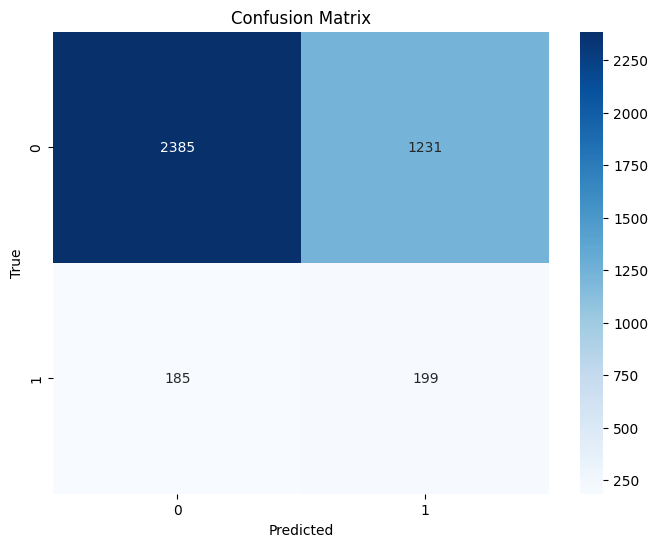

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      3616
           1       0.14      0.52      0.22       384

    accuracy                           0.65      4000
   macro avg       0.53      0.59      0.50      4000
weighted avg       0.85      0.65      0.72      4000



In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize=None)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
report = classification_report(y_test, y_pred)
print(report)

In [10]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')
test_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", test_accuracy)
print('Precison:', test_precision)
print('Recall:', test_recall)
print('F1 Score:', test_f1)
print('AUC:', test_auc)

Accuracy: 0.646
Precison: 0.5335882016815869
Recall: 0.5888988753687315
F1 Score: 0.4952503269644334
AUC: 0.5888988753687314


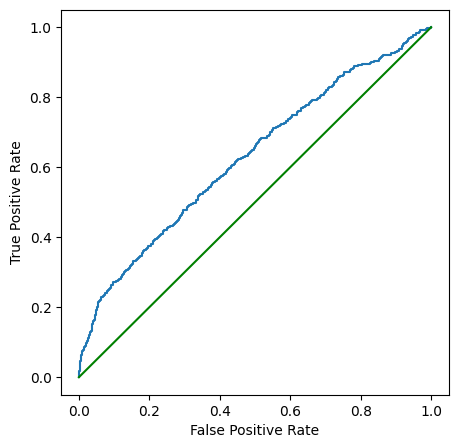

In [12]:
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    
y_proba = logistic_regression.predict_proba(X_test)
plot_auc_roc_curve(y_test, y_proba[:, 1])

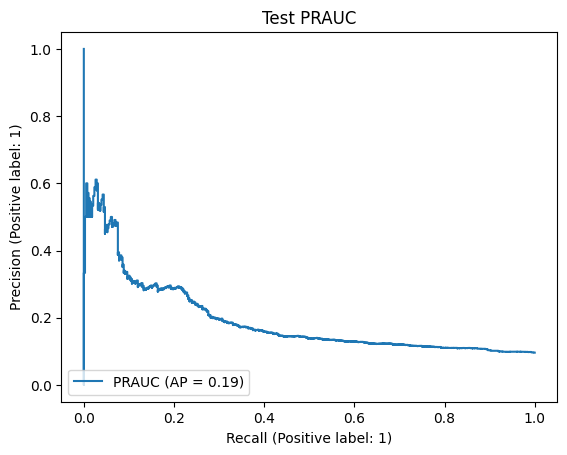

In [13]:
display = PrecisionRecallDisplay.from_estimator(
    logistic_regression, X_test, y_test, name="PRAUC")
_ = display.ax_.set_title("Test PRAUC")